In [1]:
import collections
import gc
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, Iterable, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
from core.monitor import Monitor
from modeling.image_features import ImageFeatures
from modeling.openclip_vit import OpenCLIPViT
from modeling.vit_attention import OpenCLIPAttentionViT


# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))

MA_mask: torch.Tensor = torch.load(f"experiments/saved_masks/MA_mask{batch_size}.pt", map_location=DEVICE)
AS_mask: torch.Tensor = torch.load(f"experiments/saved_masks/ranked_AS_mask{batch_size}.pt", map_location=DEVICE).isfinite()
mta_masks: Dict[int, torch.Tensor] = {
    "MA": MA_mask,
    "Artifact": AS_mask * ~MA_mask,
}

mode = "sink"
mask_type = "X -> X"
mask_layer = 9
detection_layer = 13
stop_layer = detection_layer + 1

def norm_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return torch.norm(tree_flatten(output_)[0][0], dim=-1)

model_dict = OrderedDict([
    ("Baseline", OpenCLIPAttentionViT({}, stop_layer=stop_layer)),
    ("Masked w/ bias", OpenCLIPAttentionViT(mask_config={
        layer_idx: (mode, mask_type)
        for layer_idx in range(mask_layer, ImageFeatures.NUM_LAYERS)
    }, attn_out_proj_bias=True, stop_layer=stop_layer)),
    ("Masked w/o bias", OpenCLIPAttentionViT(mask_config={
        layer_idx: (mode, mask_type)
        for layer_idx in range(mask_layer, ImageFeatures.NUM_LAYERS)
    }, attn_out_proj_bias=False, stop_layer=stop_layer)),
])

monitor_config = {"model.visual.transformer.resblocks": [
    ("layer_output_norm", norm_hook_fn),
]}
layer_output_dict: OrderedDict[str, torch.Tensor] = OrderedDict()
for k, model in model_dict.items():
    monitor = Monitor(model, monitor_config)
    log = monitor.reset()
    with torch.no_grad():
        model.load_cache({"mask": mta_masks["MA"]})
        model.forward(images)
    layer_output_dict[k] = torch.stack([t[0] for t in log["layer_output_norm"]], dim=0)
    monitor.delete()

In [5]:
layer_output_dict["Baseline"].shape

torch.Size([14, 50, 257])

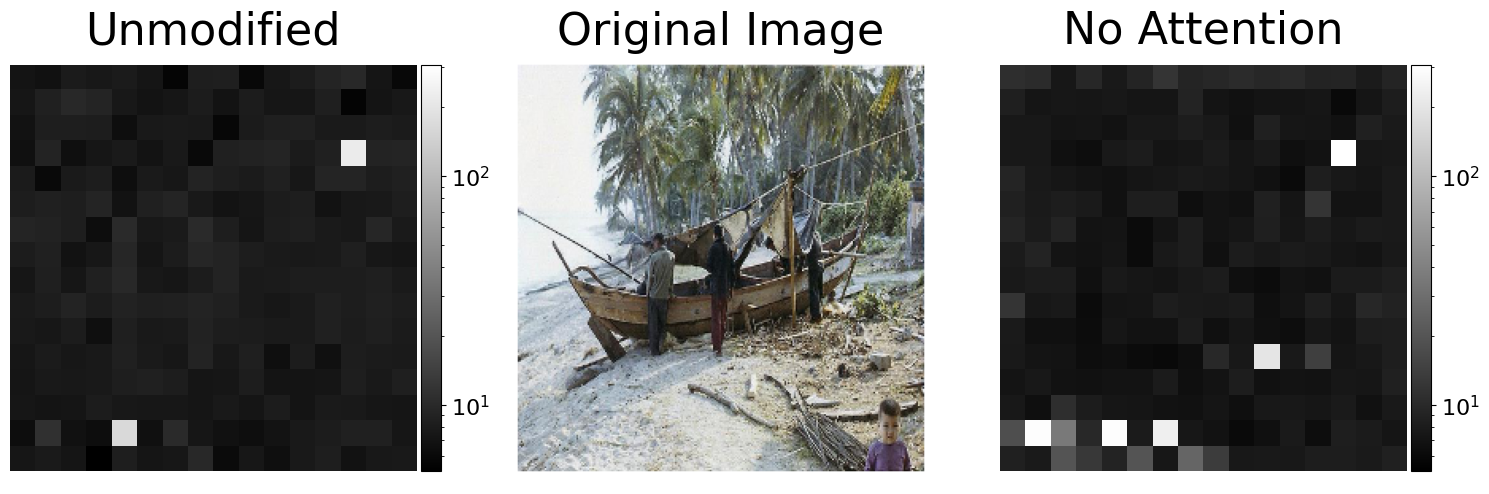

In [39]:
import matplotlib.colors
from matplotlib.axes import Axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

from visualize.base import PLOT_SCALE


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * PLOT_SCALE, PLOT_SCALE))
axs: List[Axes]

image_idx = 0

hm0 = layer_output_dict["Baseline"][detection_layer, image_idx, ImageFeatures.image_indices].view((ImageFeatures.H, ImageFeatures.W))
hm2 = layer_output_dict["Masked w/ bias"][detection_layer, image_idx, ImageFeatures.image_indices].view((ImageFeatures.H, ImageFeatures.W))

vmin = torch.min(torch.stack((hm0, hm2), dim=0)).item()
vmax = torch.max(torch.stack((hm0, hm2), dim=0)).item()
norm = matplotlib.colors.LogNorm(vmin, vmax)


im0 = axs[0].imshow(hm0.numpy(force=True), norm=norm, cmap="gray")
fig.colorbar(im0, cax=make_axes_locatable(axs[0]).append_axes("right", size="5%", pad=0.05), orientation="vertical").ax.tick_params(labelsize=16)
axs[0].axis("off")
axs[0].set_title(f"Unmodified", pad=16.0, fontsize=32.0,)

pad = 8
axs[1].imshow(einops.rearrange(
    Fn.pad(original_images[image_idx], (pad, pad, pad, pad), mode="constant", value=1.0),
    "c h w -> h w c"
).numpy(force=True))
axs[1].axis("off")
axs[1].set_title(f"Original Image", pad=0.0, fontsize=32.0,)

im2 = axs[2].imshow(hm2.numpy(force=True), norm=norm, cmap="gray")
fig.colorbar(im2, cax=make_axes_locatable(axs[2]).append_axes("right", size="5%", pad=0.05), orientation="vertical").ax.tick_params(labelsize=16)
axs[2].axis("off")
axs[2].set_title(f"No Attention", pad=16.0, fontsize=32.0,)

fig.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}/mlp_growth_comparison.pdf", bbox_inches="tight")
plt.show()

In [ ]:
lo, hi = 8, 14
max_idx = torch.argmax(layer_output_dict["Baseline"][detection_layer]).item()
x = torch.arange(lo, hi)

plt.rcParams["figure.figsize"] = (10.0, 5.0)
plt.grid(axis="both", color="gray", linestyle="--", alpha=0.5)
for k, v in layer_output_dict.items():
    plt.plot(
        x.numpy(force=True),
        v.flatten(1, -1)[lo:hi, max_idx].numpy(force=True), label=k,
    )
    
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Block Output Norm", fontsize=14)
# plt.yscale("log")
plt.title("Massive Tokens without the Attention Mechanism", fontsize=16)

plt.legend(fontsize=14)
plt.savefig(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}/mlp_growth.pdf", bbox_inches="tight")
plt.show()
